# Architecture
- langchain-core: Base abstraction for chat models and other components
- Integration packages (eg. langchain-openai, langchain-anthropic, etc.): Important integrations have been split into lightweight packages that are co-maintained by the Langchain team and the integration developers.
- langchain: Chains, agents and retrieval strategies that make up an application's cognitive architecture.
- langchain-community: Third-party integration that are community maintained.
- langgraph: Orchestration framework for combining Langchain components into production ready applications with persistence streaming and other key featues

### BaseChatModel
Base class for chat models

Method|Input|Output|Description|
|--|--|--|--|
|invoke|str List[dict tuple BaseMessage] PromptValue|BaseMessage|A single chat model call.|
|ainvoke|"|BaseMessage|Defaults to running invoke in an async executor|
|stream|‘’’|Iterator[BaseMessageChunk]|Defaults to yielding output of invoke.|
|astream|‘’’|AsyncIterator[BaseMessageChunk]|Defaults to yielding output of ainvoke.|

RunnableLambda converts python callable into a runnable.

Callable is any object called like a function, eg. Functions, Methods, Classes, Instances with method `__call__`.

Runnable is a interface that has invoke method.

So we add the invoke method to the callable when we convert to RunnableLambda.

In [23]:
# This is a RunnableLambda
from langchain_core.runnables import RunnableLambda

def add_one(x: int) -> int:
    return x + 1

runnable = RunnableLambda(add_one)

runnable.invoke(1) # returns 2
runnable.batch([1, 2, 3]) # returns [2, 3, 4]

# Async is supported by default by delegating to the sync implementation
await runnable.ainvoke(1) # returns 2
await runnable.abatch([1, 2, 3]) # returns [2, 3, 4]

async def add_one_async(x: int) -> int:
    return x + 1

runnable = RunnableLambda(add_one, afunc=add_one_async)
runnable.invoke(1) # Uses add_one
await runnable.ainvoke(1) # Uses add_one_async

2

#### format_docs

In [24]:
from typing import List
from langchain.schema import Document 
from langchain_core.runnables import RunnableLambda

def format_docs(docs: List[Document]) -> str:
    '''Format the docs.'''
    return ", ".join([doc.page_content for doc in docs])

format_docs = RunnableLambda(format_docs)

#### some_tool

In [25]:
from langchain_core.tools import tool

@tool
def some_tool(x: int, y: str) -> dict:
    '''Some_tool.'''
    return {"x": x, "y": y}

#### prompt

In [26]:
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate.from_messages(
    [("system", "You are Cat Agent 007"), ("human", "{question}")]
).with_config({"run_name": "my_template", "tags": ["my_template"]})

In [27]:
from langchain_core.runnables import RunnableLambda

async def reverse(s: str) -> str:
    return s[::-1]

chain = RunnableLambda(func=reverse)

events = [
    event async for event in chain.astream_events("hello", version="v2")
]

In [28]:
events

[{'event': 'on_chain_start',
  'data': {'input': 'hello'},
  'name': 'reverse',
  'tags': [],
  'run_id': '62ef125d-df2c-42fa-8a1b-c17efbc40bf3',
  'metadata': {},
  'parent_ids': []},
 {'event': 'on_chain_stream',
  'run_id': '62ef125d-df2c-42fa-8a1b-c17efbc40bf3',
  'name': 'reverse',
  'tags': [],
  'metadata': {},
  'data': {'chunk': 'olleh'},
  'parent_ids': []},
 {'event': 'on_chain_end',
  'data': {'output': 'olleh'},
  'run_id': '62ef125d-df2c-42fa-8a1b-c17efbc40bf3',
  'name': 'reverse',
  'tags': [],
  'metadata': {},
  'parent_ids': []}]

## Chat Models

In [29]:
import getpass
import os

if not os.environ.get("LANGSMITH_API_KEY"):
  os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for LangSmith: ")

In [30]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "pr-overcooked-push-81"

In [31]:
import langsmith
from langchain_core.tracers.context import tracing_v2_enabled
from langchain.chat_models import init_chat_model

langsmith_client = langsmith.Client(
 api_key=os.environ.get("LANGSMITH_API_KEY"),
 api_url='https://api.smith.langchain.com'
)
with tracing_v2_enabled(client=langsmith_client, project_name="default"):
    model = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")
    model.invoke("Hello, world!")

In [32]:
from langchain.chat_models import init_chat_model

model = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")
model.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen2.5-coder:14b', 'created_at': '2025-03-26T02:40:56.063796575Z', 'done': True, 'done_reason': 'stop', 'total_duration': 178903129, 'load_duration': 8050710, 'prompt_eval_count': 33, 'prompt_eval_duration': 2000000, 'eval_count': 10, 'eval_duration': 165000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-fd703b10-742e-4b43-9c65-ee4cb5f4c3a4-0', usage_metadata={'input_tokens': 33, 'output_tokens': 10, 'total_tokens': 43})

In [33]:
from langchain_ollama import ChatOllama
import langsmith
from langchain_core.tracers.context import tracing_v2_enabled
langsmith_client = langsmith.Client(
 api_key='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',
 api_url='https://api.smith.langchain.com'
)
llm = ChatOllama(
    model="qwen2.5-coder:14b",
    temperature=0,
    # other params...
)
from langchain_core.messages import AIMessage

messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
with tracing_v2_enabled(client=langsmith_client, project_name="default"):
    ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'aime programmer.", additional_kwargs={}, response_metadata={'model': 'qwen2.5-coder:14b', 'created_at': '2025-03-26T02:40:56.22073688Z', 'done': True, 'done_reason': 'stop', 'total_duration': 123745494, 'load_duration': 9008977, 'prompt_eval_count': 33, 'prompt_eval_duration': 15000000, 'eval_count': 6, 'eval_duration': 96000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-c06f7835-c6ce-4aed-acae-9720ebe38223-0', usage_metadata={'input_tokens': 33, 'output_tokens': 6, 'total_tokens': 39})

In [34]:
!uv pip install langchain
!uv pip install -U langchain-ollama

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 3ms


Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 26 packages in 235ms                                        
⠙ Preparing packages... (0/4)                                                   
⠙ Preparing packages... (0/4)----     0 B/130.02 KiB                    
⠙ Preparing packages... (0/4)---- 14.91 KiB/130.02 KiB                  
⠙ Preparing packages... (0/4)---- 30.91 KiB/130.02 KiB                  
⠙ Preparing packages... (0/4)---- 46.91 KiB/130.02 KiB                  
⠙ Preparing packages... (0/4)---- 62.91 KiB/130.02 KiB                  
⠙ Preparing packages... (0/4)---- 78.91 KiB/130.02 KiB                  
⠙ Preparing packages... (0/4)---- 94.91 KiB/130.02 KiB                  
⠙ Preparing packages... (0/4)---- 110.91 KiB/130.02 KiB                 
⠙ Preparing packages... (0/4) 126.91 KiB/130.02 KiB                 
Prepared 4 packages in 40ms                                                  
Uninstalled 4 packages in 5ms
Install

In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

deepseek_model = OllamaLLM(model="deepseek-r1:14b")

deepseek_chain = prompt | deepseek_model

deepseek_chain.invoke({"question": "What is LangChain?"})

'<think>\nOkay, so I need to figure out what LangChain is. I\'ve heard the term before in the context of AI and machine learning, but I\'m not exactly sure what it refers to. Let me try to break this down.\n\nFirst, I know that "chain" often implies a sequence or a series of connected parts. In programming, especially with libraries and frameworks, chaining can refer to linking together different functions or modules to create a more complex system. So maybe LangChain is something related to combining different AI components?\n\nI remember hearing about various machine learning frameworks like TensorFlow and PyTorch. There\'s also the concept of transformers in NLP, like BERT or GPT models. Perhaps LangChain is a framework that allows these different parts to work together more seamlessly?\n\nWait, I think there was something called "LangChain" specifically for language models. Maybe it\'s a way to create chains where each step processes data and passes it along, much like a pipeline. 

In [36]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

qwen_model = OllamaLLM(model="qwen2.5-coder:14b")

qwen_chain = prompt | qwen_model

qwen_chain.invoke({"question": "What is LangChain?"})

"LangChain is an open-source framework designed to simplify the process of building language models and applications that leverage these models. It provides a set of tools, libraries, and components that enable developers to easily create, deploy, and manage natural language processing (NLP) systems.\n\nTo break it down further:\n1. **Open-Source**: This means that LangChain's source code is available for anyone to view, use, modify, and distribute. It fosters collaboration and innovation within the developer community.\n2. **Framework**: It serves as a structured approach or set of guidelines for building software. In this case, it provides a framework for working with language models.\n3. **Simplify the Process**: LangChain aims to make it easier for developers to work with complex NLP technologies. This includes abstracting away some of the technical details so that developers can focus more on the specific tasks they need to accomplish.\n4. **Build, Deploy, Manage**: These are key 

In [37]:
qwen_chain.invoke({"question": "What is 5*5?"})

'To solve the problem of multiplying 5 by 5:\n\n1. First, understand that multiplication is repeated addition. So, 5 * 5 can be thought of as adding 5 to itself 5 times.\n2. We start with 0 and add 5 five times:\n   - 0 + 5 = 5\n   - 5 + 5 = 10\n   - 10 + 5 = 15\n   - 15 + 5 = 20\n   - 20 + 5 = 25\n\nSo, 5 * 5 equals 25.'

In [38]:
deepseek_chain.invoke({"question": "What is 5*5?"})

'<think>\nTo find the product of 5 multiplied by 5, I can start by understanding that multiplication is essentially repeated addition.\n\nTherefore, 5 times 5 means adding the number 5 to itself five times.\n\nPerforming this calculation gives me a total of 25.\n</think>\n\n**Question:** What is \\(5 \\times 5\\)?\n\n---\n\n**Solution:**\n\nTo find the product of \\(5 \\times 5\\), follow these simple steps:\n\n1. **Understand Multiplication as Repeated Addition:**\n   - \\(5 \\times 5\\) means adding the number 5 to itself five times.\n\n2. **Perform the Calculation:**\n   \\[\n   5 + 5 + 5 + 5 + 5 = 25\n   \\]\n\n---\n\n**Answer:** \\(\\boxed{25}\\)'

In [39]:
qwen_chain.invoke({"question": "What is 2555*2555?"})

"To calculate 2555 * 2555, you can use the formula for squaring a number or perform direct multiplication. Here’s a step-by-step breakdown using both methods:\n\n### Method 1: Using the Squaring Formula\n\nThe square of a number \\( n \\) is given by:\n\\[ n^2 = (n - a)(n + a) + a^2 \\]\n\nWhere \\( a \\) is chosen to make the calculation easier. Let's choose \\( a = 500 \\):\n- Here, \\( n = 2555 \\)\n- So, \\( a = 500 \\)\n\nNow plug these values into the formula:\n\\[ (2555)^2 = (2555 - 500)(2555 + 500) + 500^2 \\]\n\\[ = 2055 \\times 3055 + 250000 \\]\n\nNow calculate each part:\n- \\( 2055 \\times 3055 = 6271025 \\)\n- \\( 250000 = 250000 \\)\n\nAdd these results together:\n\\[ 6271025 + 250000 = 6521025 \\]\n\nSo, \\( 2555 \\times 2555 = 6521025 \\).\n\n### Method 2: Direct Multiplication\n\nYou can also perform the multiplication directly:\n\\[ 2555 \\times 2555 \\]\n- First, multiply 2555 by 5 (the units digit of 2555):\n\\[ 2555 \\times 5 = 12775 \\]\n\n- Next, multiply 2555 b

In [40]:
deepseek_chain.invoke({"question": "What is 2555*2555?"})

"<think>\nTo calculate 2555 multiplied by 2555, I can start by breaking down the numbers to make the multiplication easier.\n\nFirst, I notice that 2555 is equal to 2000 plus 555. So, I'll express the multiplication as (2000 + 555) multiplied by itself, which forms a squared term: (2000 + 555)^2.\n\nNext, I'll apply the algebraic identity for squaring a binomial: (a + b)^2 = a^2 + 2ab + b^2. Here, a is 2000 and b is 555.\n\nCalculating each part separately:\n1. a squared is 2000 multiplied by 2000, which equals 4,000,000.\n2. 2 times a times b is 2 times 2000 times 555, totaling 2,220,000.\n3. b squared is 555 multiplied by 555, resulting in 308,025.\n\nFinally, I'll add all these components together: 4,000,000 plus 2,220,000 equals 6,220,000, and adding 308,025 gives a total of 6,528,025.\n\nTherefore, the product of 2555 multiplied by itself is 6,528,025.\n</think>\n\nCertainly! Let's calculate \\(2555 \\times 2555\\) step by step.\n\n### Step 1: Break Down the Multiplication\nWe can

In [41]:
2555*2555

6528025

## Techniques to mitigate LLM limitations
limitations: outdated knowledge, inability to take action, lack of context, hallucination risks, biases and discrimination, lack of transparency, lack of context

Mitigation techniques:
- Retrieval augmenation: This technique accesses knowledge bases to supplement an LLM's outdated training data, providing external context and reducing hallucination risk.
- Chaining: This technique integrates action like searches and calculations.
- Prompt engineering: This involves the careful crafting of prompts by providing critical context the guides appropriate responses.
- Monitoring, filtering, and review: This involves ongoing and effective oversight of emerging issues regarding the application's input and output to detect issues. Both manual reviews and automated filters then correct potential problems with the output. This includes the following:
- - Filters, like block lists, sensitivity classifiers, and banned word filters, can automatically flag issues.
  - Constitutional principles monitor and filter unethical and inappropriate content.
  - Human reviews provide insight into model behaviour and output.
- Memory: Retains conversation context by persisting conversation data and context across interactions.
- Fine-tuning: Training and tuning the LLM on more appropriate data for the application domain and principles. This adapts the model's behaviour for its specific purpose.

### LLM App
LLM apps typically have the following components:
- A client layer to collect user input as text queries or decisions.
- A prompt engineering layer to construct prompts that guide the LLM.
- An LLM backend to analyze prompts and produce relevant text responses.
- An output parsing layer to interpret LLM responses for the application interface.
- Optional integration with external services via function APIs, knwoledge bases, and reasoning algorithms to augment the LLM's capabilities.



In [42]:
!uv pip install graphviz
# !sudo apt-get install graphviz -y

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 3ms


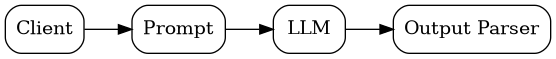

In [43]:
from graphviz import Digraph
from IPython.display import Image

def create_llm_flow():
    # Create a new directed graph
    dot = Digraph(comment='LLM Processing Flow')
    
    # Configure graph attributes
    dot.attr(rankdir='LR')  # Left to right layout
    dot.attr('node', shape='box', style='rounded')
    
    # Add nodes
    dot.node('client', 'Client')
    dot.node('prompt', 'Prompt')
    dot.node('llm', 'LLM')
    dot.node('parser', 'Output Parser')
    
    # Add edges with arrows
    dot.edge('client', 'prompt')
    dot.edge('prompt', 'llm')
    dot.edge('llm', 'parser')
    
    return dot

# Create and save the graph
flow = create_llm_flow()
flow.render('llm_flow', format='png', cleanup=False)
Image("./llm_flow.png")

LLM apps can integrate external services via:
- Function APIs to access web tools and databases.
- Advanced reasoning algorithms for complex logic chains.
- Retrieval augmented generation via knowledge bases.

Retrieval augmented generation (RAG), enhances the LLM with external knowledge. These extensions expand the capabilities of LLM apps beyond the LLM's knowledge alone. For instance:
- Function calling allows parameterized API requests.
- SQL functions enable conversational database queries.
- Reasoning algorithms linke chain-of-though fcilitate multi-step logic.


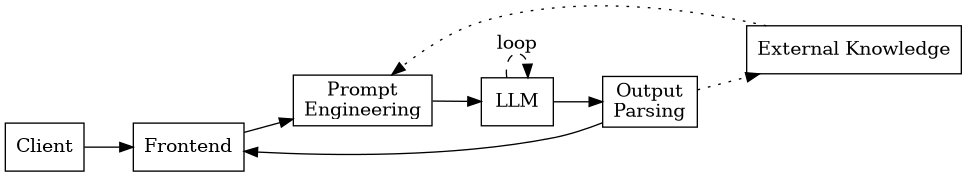

In [44]:
from graphviz import Digraph

def create_llm_flow():
    dot = Digraph()
    
    # Basic left-to-right layout
    dot.attr(rankdir='LR')
    
    # Simple boxes for nodes
    dot.attr('node', shape='box')
    
    # Add nodes
    dot.node('client', 'Client')
    dot.node('frontend', 'Frontend')
    dot.node('prompt', 'Prompt\nEngineering')
    dot.node('llm', 'LLM')
    dot.node('parser', 'Output\nParsing')
    dot.node('ext', 'External Knowledge')
    
    # Main flow edges (solid)
    dot.edge('client', 'frontend')
    dot.edge('frontend', 'prompt')
    dot.edge('prompt', 'llm')
    dot.edge('llm', 'parser')
    dot.edge('parser', 'frontend')
    
    # Dotted connections
    dot.edge('ext', 'prompt', style='dotted')
    dot.edge('parser', 'ext', style='dotted')
    
    # LLM self-loop
    dot.edge('llm', 'llm', style='dashed', label='loop')
    
    return dot

# Generate the diagram
g = create_llm_flow()
g.save('advance_llm_flow.dot')
g.render('advance_llm_flow', format='png', cleanup=False)
Image("./advance_llm_flow.png")

# Key Components of LangChain
- Chains
- Agent
- Memory
- Tools

### Chains
Chains: a sequence of calls to components, which include other chains.

Chains enables composing modular components into reusable pipelines.

Eg. put together multiple LLM calls and other components in a swquence to create complex applicaitons.

Prompt chaining: a technique that can be used to improve the performance of LangChain applicaitons, which involves chaining together multiple prompts to autocomplete a more complex response. More complex chains integrate models with tools like LLMMath, or SQLDatbaseChain. theese are called utility chains because they combine language models with specific tools.

Benefits that Chains deliver
- Modularity: Logic is divided into reusable components.
- Composability: Components can be sequenced flexibly.
- Readability: Each step in a pipeline is clear.
- Maintainability: Steps can be added, removed and swapped.
- Reusability: Common pilelines becomes configurable chains.
- Tool integration: Easily incoporate LLMs, databases, APIs, etc.
- Productivitiy: Quickly build prototypes of configurable chains.

Chains are wrappers around multiple components - ranging from LLMs, APIs, libraries, databases, utility functions, etc.

They are one of the core components of LangChain and enable you to really augment your LLM in a structed and easy way. You can craft your own chains or you can use the many existing ones. Chains are super important because they allow you to become a lot more creative with LLMs and solve increasing complex problems, through integrating various entities.

These chains can be really simple such as having one LLM or they can be increasingly complex - combining multiple entities (also sometimes called utility chains).

The ones related to RAG and conversational history are called
- `ConversationChain`
- `ConversationRetrievalChain`

The conversation chain extends a simpler chain called an `LLMChain` which just receives a prompt and LLM and makes makes the call to the specified LLM and spits out the output.

`ConversationChain` builds on this algorithm to load historical context into the prompt that is then passed into the LLMChain and queried.

`ConversationalRetrievalChain` is for retrieving information from a datasource. It does 3 things
1. It takes the chat history in and crafts an entirely new question based on history and new query.
2. This question is passed into the retriever (ie., it becomes the query to the vector database)
3. After getting the right documents, it passes the original question and fetched documents into the LLM jto get a response

# Agents
Agent is an application thati s powered by an LLM and interacts with differetn APIs, entities, libraries, chains, tools, etc.

The LLM is the "brain" that makes the decisions on which chain and/or tools to execute, what to do with the output, and how to interpret various inputs/outputs and human interactions.

Agent is an autonomous software entity that is capable of taking actions to accomplish goals and tasks.

Both chains and agents is about the composiblity of LLMs and other components to work together.

Difference between agents and chains
- Agents do so by orchestrating chains while chains compose lower-level modules. While chains define reusable logic by sequencing components, agents leverage chains to take goal-driven actions.

Action combine and orchestrate chains. Agents obeserves the environment, decides which chain to execute based on that observation, takes the chain's specified action and repeats.

Agents decide which actions to take using LLMs as reasoning engines. The LLM is prompted with available tools, user input, and previous steps. It then selects the next action or final response.

Tools are functions the agent calls to take real-world actions. Providing the right tools and effectively describing them is critical for action to accomplish goals.

The agent executor runtime orchestrates the loop of querying the agent, executing tool actions, and feeding observations back. This handles lower-level complexities like error handling, logging, and parsing.

Agents provide several key benefits:
- Goal-oriented execution: Agents plan chains of logic targeting specific goals.
- Dynamic responses: Observing environment changes lets agent react and adapt.
- Statefulness: Agents can maintain memory and context across interactions.
- Robustness: Errors can be handled by catching exceptions and trying alternative chains.
- Composition: Agent logic combines reusable component chains.

Together, this enables agent to handle complex, multi-step workflows and continuously interactive applications like chatbots.

Agent is a way of forcing the LLM to "think", that is a way of prompting the LLM to hink in a certain style. For example, a very simple way would gbe to jsut say "think step by step" after asking a question. 

LangChain provides a range of prebuilt algorityms for thinking:
- `zero-shot-react-description`
- `react-docstore`
- `conversational-react-description`
- `chat-zero-shot-react-description`
- `chat-conversational-react-description`
- `self-ask-with-search`

## ReAct
ReAct stands for reason and act.
Paper 

In [45]:
# Installing Poetry
!uv pip install poetry

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 37 packages in 180ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)----     0 B/38.17 KiB                     
⠙ Preparing packages... (0/1)---- 14.91 KiB/38.17 KiB                   
⠙ Preparing packages... (0/1)---- 30.91 KiB/38.17 KiB                   
Prepared 1 package in 33ms                                                   
Uninstalled 1 package in 0.43ms
Installed 1 package in 4ms                                  
 - keyring==24.3.1
 + keyring==25.6.0


In [46]:
import os
os.environ["OPENAI_API_KEY"] = "<your token>"

In [47]:
!echo $OPENAI_API_KEY

<your token>


In [48]:
# config.py
import os
OPENAI_API_KEY = "... "

# I'm omitting all other keys
def set_environment():
    variable_dict = globals().items()
    for key, value in variable_dict:
        if "API" in key or "ID" in key:
             os.environ[key] = value

In [49]:
!echo $OPENAI_API_KEY

...


In [50]:
# variable_dict = globals().items()
# for key, value in variable_dict:
#     if key:
#         print(f'key: {key}')

In [51]:
import os
environment = os.environ

## Fake LLM

In [52]:
! uv pip install langchain-community langchain-core langchain-llm langchain-experimental langchain[docarray]

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 5 packages in 5ms


In [53]:
from langchain.llms.fake import FakeListLLM
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools import PythonREPLTool

tools = [PythonREPLTool()]
responses = ["Action: Python_REPL\nAction Input: print(2 + 2)", "Final Answer: 4"]
llm = FakeListLLM(responses=responses)
agent = initialize_agent(
 tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)
agent.run("whats 2 + 2")

/tmp/ipykernel_1612885/2037961426.py:10: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(
/tmp/ipykernel_1612885/2037961426.py:13: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  agent.run("whats 2 + 2")
Python REPL can execute arbitrary code. Use with caution.




> Entering new AgentExecutor chain...
Action: Python_REPL
Action Input: print(2 + 2)
Observation: 4

Thought:Final Answer: 4

> Finished chain.


'4'

In [54]:
from langchain.tools.base import BaseTool
from langchain.pydantic_v1 import BaseModel, Field, root_validator
from langchain_experimental.tools import PythonREPLTool

class PythonREPLTool(BaseTool):
    """A tool for running python code in a REPL."""

    name: str = "Python_REPL"
    description: str = (
        "A Python shell. Use this to execute python commands. "
        "Input should be a valid python command. "
        "If you want to see the output of a value, you should print it out "
        "with `print(...)`."
    )
d

NameError: name 'd' is not defined

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools import PythonREPLTool

tools = [PythonREPLTool()]
qwen_llm = OllamaLLM(temperature=0., model="qwen2.5-coder:14b")

agent = initialize_agent(
 tools, qwen_llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)
agent.run("whats 4 + 4")




> Entering new AgentExecutor chain...
To calculate 4 + 4, I will use Python's addition operator.

Action: Python_REPL
Action Input: print(4 + 4)
Observation: 8

I now know the final answer.
Final Answer: 4 + 4 equals 8.

> Finished chain.


'4 + 4 equals 8.'

## Hugging Face
Hugging Face provides Hugging Face Hub, a platform for hosting Git-based code repositories, machine learnning models, dtasets and web applications.

In [ ]:
!uv pip install langchain-huggingface

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 61 packages in 566ms                                        
Prepared 2 packages in 72ms                                              
Installed 2 packages in 15ms==3.4.1                         
 + langchain-huggingface==0.1.2
 + sentence-transformers==3.4.1


In [ ]:
from langchain_huggingface import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="microsoft/Phi-3-mini-4k-instruct",
    task="text-generation",
    pipeline_kwargs={
        "max_new_tokens": 100,
        "top_k": 50,
        "temperature": 0.1,
    },
)
llm.invoke("In which country is Tokyo?")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/home/yi/Documents/tutorials/tutorials/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


'In which country is Tokyo?\n\n# Answer\nTokyo is the capital city of Japan. It is located on the eastern coast of the main island Honshu and is the political, economic, and cultural center of the country. Tokyo is known for its modernity, blending traditional Japanese culture with cutting-edge technology and fashion. It is also one of the most populous metropolitan areas in the world.'

In [ ]:
from huggingface_hub import list_models

In [ ]:
def list_most_popular(task: str):
     for rank, model in enumerate(
         list_models(filter=task, sort="downloads", direction=-1)
      ):
         if rank == 30:
             break
         print(f"{model.id}, {model.downloads}\n")
list_most_popular("text-classification")

cross-encoder/ms-marco-MiniLM-L-6-v2, 10485603

distilbert/distilbert-base-uncased-finetuned-sst-2-english, 7730948

papluca/xlm-roberta-base-language-detection, 4986307

laurievb/OpenLID-v2, 4836437

yiyanghkust/finbert-tone, 4324232

facebook/bart-large-mnli, 3258391

cardiffnlp/twitter-roberta-base-sentiment-latest, 2431001

mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis, 2391929

cardiffnlp/twitter-xlm-roberta-base-sentiment, 2060421

cardiffnlp/twitter-roberta-base-sentiment, 2056152

facebook/roberta-hate-speech-dynabench-r4-target, 1953988

lxyuan/distilbert-base-multilingual-cased-sentiments-student, 1920043

nlptown/bert-base-multilingual-uncased-sentiment, 1486629

lucadiliello/BLEURT-20-D12, 1214117

BAAI/bge-reranker-large, 1173427

ProsusAI/finbert, 1131377

cardiffnlp/twitter-roberta-base-emotion, 1110092

pysentimiento/robertuito-sentiment-analysis, 1099897

cross-encoder/ms-marco-TinyBERT-L-2-v2, 1052639

cross-encoder/ms-marco-MiniLM-L-4-v2, 1040183


In [ ]:
from transformers import pipeline
customer_email = """
I am writing to pour my heart out about the recent unfortunate experience
I had with one of your coffee machines that arrived broken. I anxiously
unwrapped the box containing my highly anticipated coffee machine.
However, what I discovered within broke not only my spirit but also any
semblance of confidence I had placed in your brand.
Its once elegant exterior was marred by the scars of travel, resembling a
war-torn soldier who had fought valiantly on the fields of some espresso
battlefield. This heartbreaking display of negligence shattered my dreams
of indulging in daily coffee perfection, leaving me emotionally distraught
and inconsolable
"""
sentiment_model = pipeline(
 task="sentiment-analysis",
 model="cardiffnlp/twitter-roberta-base-sentiment"
)
print(sentiment_model(customer_email))

Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.7691410779953003}]


In [ ]:
print(sentiment_model("I am very super happy"))

[{'label': 'LABEL_2', 'score': 0.9900000691413879}]


In [ ]:
print(sentiment_model("Recently my cat has died"))

[{'label': 'LABEL_0', 'score': 0.9214368462562561}]


## Mitigating hallucinations throught fact-checking
fact checking is verifying claims made by LLM's aggains evidence from external sources.

Fact-checking 3 main stages:
1. Claim detection: Identifying parts needing verification.
2. Evidence retrieval: Find sources supporing or refuting the claim.
3. Verdict prediction: Assess claim veracity based on evidence.

LLMCheckerchain, is a chain for fact-checking, the model is prompted sequentially - first, to make the assumptions explicit, which looks like this:


In [ ]:
from langchain.chains import LLMCheckerChain
from langchain_ollama.llms import OllamaLLM
from langchain.cache import InMemoryCache  # if available in your version

qwen_model = OllamaLLM(model="qwen2.5-coder:14b", temperature="0.7")
checker_chain = LLMCheckerChain.from_llm(qwen_model, verbose=True)
checker_chain.model_rebuild()  # Finaliz

text = "What type of mammal lays the biggest eggs?"
checker_chain.invoke(text)



> Entering new LLMCheckerChain chain...


> Entering new SequentialChain chain...

> Finished chain.

> Finished chain.


{'query': 'What type of mammal lays the biggest eggs?',
 'result': "Based on the information provided in the assertions, the mammal that lays the biggest eggs is the platypus. Despite being a relatively small animal, the egg laid by a platypus is larger in proportion to its body size compared to other mammals. However, it's important to note that while an ostrich egg is heavier and larger in absolute terms, it belongs to the bird kingdom, not the mammal kingdom."}

## Summarization

In [ ]:
from langchain_ollama.llms import OllamaLLM
prompt = """
Summarize this text in one sentence:
{text}
"""

qwen_model = OllamaLLM(model="qwen2.5-coder:14b", temperature="0.7")
summary = qwen_model(prompt.format(text=text))
print(summary)

In [ ]:
prompt.format(text=text)

'\nSummarize this text in one sentence:\nWhat type of mammal lays the biggest eggs?\n'

In [ ]:
!uv pip install langchain_decorators

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 7ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
! uv pip install --upgrade langchain_decorators

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
⠙ langchain-decorators==0.6.1                                                   

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 42 packages in 383ms                                        
Prepared 2 packages in 939ms                                             
Uninstalled 2 packages in 49ms
Installed 2 packages in 19ms                                
 - attrs==24.3.0
 + attrs==25.1.0
 - numpy==2.2.1
 + numpy==2.2.3


In [ ]:
from langchain_decorators import llm_prompt

@llm_prompt
def summarize(text:str, length="short") -> str:
 """
 Summarize this text in {length} length:
 {text}
 """
 return
summary = summarize(text="let me tell you a boring story from when I was young...")

RuntimeError: no validator found for <class 'langchain_core.messages.ai.AIMessage'>, see `arbitrary_types_allowed` in Config

## Prompt templates

In [ ]:
from langchain import PromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain.schema import StrOutputParser
llm = OllamaLLM(model="qwen2.5-coder:14b")
prompt = PromptTemplate.from_template(
    "Summarize tis text: {text}?"
)
runnable = prompt | llm | StrOutputParser()
summary = runnable.invoke({"text": text})

In [ ]:
runnable

PromptTemplate(input_variables=['text'], input_types={}, partial_variables={}, template='Summarize tis text: {text}?')
| OllamaLLM(model='qwen2.5-coder:14b')

In [ ]:
summary

'The mammal that lays the biggest eggs is the platypus. Platypuses are monotremes, which means they lay eggs instead of giving birth to live young. The average size of a platypus egg is about 1.5 centimeters in length and weighs around 0.2 grams. This makes them the largest eggs laid by any mammal.'

In [ ]:
summary

'The type of mammal that lays the largest eggs is the platypus. While it is not commonly known, the platypus is an egg-laying mammal, scientifically classified as monotremes along with the echidnas. Platypus eggs are about 2 cm in length and weigh around 0.1 grams. Although they are relatively small by human standards, compared to other mammals, platypus eggs are indeed some of the largest laid by any mammal.'

## Chain of density
Chain of density, a prompt-guided techniques to incrementallly increase the information density of GPT-4 gnerated summaries while controlling length.

This is the prompt to sue with CoD:

In [ ]:
template = """Article: { text }
You will generate incressingly concise, entity-dense summaries of the 
above article.
Repeat the following 2 steps 5 times.
Step 1. Identify 1-3 information entities (";" delimited) from the 
article which are missing from the previously generated summary.
Step 2. Write a new, denser summary of indentical length which covers 
every entity and detail from the previous summary plus the missing 
entities.
A missing entity is:
- relevant to the main story,
- specific yet concise (5 words or fewer),
- novel (not in the previous summary),
- faithful (present in the article),
- anywhere (can be located anywhere in the article).
Guideline:
- The first summary should be long (4-5 sentences, ~80 workds) yet highly
non-specific, containing little information beyond the entities marked as missing.
Use overly verbose language and fillers (e.g., "this article discussses") to reach ~80 words.
- Make every word count: rewrite the previous summary to improve flow and make space
for additional entities.
- Make space with fusion, compression, and removal of uninformative phrases
like "the article discusses".
- The summaries should become highly dense and concise yet self-contained, i.e.,
easily understood without the article.
- Missing entities can appear anywhere in the new summary.
- Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
Remember, use the exact same number of words for each summary.
Answer in JSON. The JSON should be a list (length 5) of dictionaries whose
keys are "Missing_Entities" and "Denser_Summary".
"""

# Map-Reduce pipelines
Key steps
1. Map: Each document is passed through a summarization chain (LLM chain)
2. Collapse (optional): The summarize documents are combined into a single document.
3. Reduce: The collapse document goes through a final LLM chain to produce the output.

The map step applies a chain to each document in parallel. the reduce step aggregates the mapped output and gneerates the final result.



In [ ]:
! uv pip install langchain

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 7ms


In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain_ollama.llms import OllamaLLM
from langchain.document_loaders import PyPDFLoader
# pdf_file_path = "<pdf_file_path>"
# pdf_loader = PyPDFLoader(pdf_file_path)
# docs = pdf_loader.load_and_split()
# llm = OllamaLLM(model="qwen2.5-coder:14b")
# chain = load_summarize_chain(llm, chain_type="map_reduce")
# chain.run(docs)

In [ ]:
! uv pip install pypdf

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 1 package in 226ms                                          
Prepared 1 package in 61ms                                               
Installed 1 package in 11ms                                 
 + pypdf==5.3.0


In [ ]:
pdf_file_path = "openresume-resume.pdf"
pdf_loader = PyPDFLoader(pdf_file_path)
docs = pdf_loader.load_and_split()

In [ ]:
llm = OllamaLLM(model="qwen2.5-coder:14b")
chain = load_summarize_chain(llm, chain_type="map_reduce")
response = chain.invoke(docs)

### Monitor token usage

Can't get tokens from openai callback using ollama

In [ ]:
from langchain.callbacks import get_openai_callback
with get_openai_callback() as cb:
    response = chain.invoke(docs) 
    # print(response)
    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Total Cost (USD): ${cb.total_cost}")

Total Tokens: 0
Prompt Tokens: 0
Completion Tokens: 0
Total Cost (USD): $0.0


### Extracting information from documents

In [ ]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain
from langchain.document_loaders import PyPDFLoader
from pydantic import BaseModel, Field
from typing import Optional
import os

# Define your Pydantic models
class Experience(BaseModel):
    start_date: Optional[str]
    end_date: Optional[str]
    description: Optional[str]

class Study(Experience):
    degree: Optional[str]
    university: Optional[str]
    country: Optional[str]
    grade: Optional[str]

class WorkExperience(Experience):
    company: str
    job_title: str

class Resume(BaseModel):
    first_name: str
    last_name: str
    linkedin_url: Optional[str]
    nationality: Optional[str]
    skill: Optional[str]
    study: Optional[Study]
    work_experience: Optional[WorkExperience]
    hobby: Optional[str]

# Load and split your PDF document
pdf_file_path = os.path.expanduser("openresume-resume.pdf")
pdf_loader = PyPDFLoader(pdf_file_path)
docs = pdf_loader.load_and_split()

# Initialize the output parser
parser = PydanticOutputParser(pydantic_object=Resume)

# Create the prompt template
prompt = PromptTemplate(
    template="Extract the following information from the provided document:\n{format_instructions}\n\nDocument:\n{document}",
    input_variables=["document"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Initialize the ChatOllama model
llm = ChatOllama(model="qwen2.5-coder:14b", format="json", temperature=0)

# Create the LLMChain
# chain = LLMChain(llm=llm, prompt=prompt)
chain = prompt | llm | SimpleJsonOutputParser()  

summary = chain.invoke({"document": doc})


In [ ]:
summary

{'first_name': 'John',
 'last_name': 'Doe',
 'linkedin_url': 'linkedin.com/in/john-doe',
 'nationality': None,
 'skill': 'HTML, TypeScript, CSS, React, Python, C++',
 'study': {'start_date': 'Sep 2019',
  'end_date': 'May 2023',
  'description': 'Won 1st place in 2022 Education Hackathon, 2nd place in 2023 Health Tech Competition\nTeaching Assistant for Programming for the Web (2022 - 2023)\nCoursework: Object-Oriented Programming (A+), Programming for the Web (A+), Cloud Computing (A), Introduction to Machine Learning (A-), Algorithms Analysis (A-)',
  'degree': 'Bachelor of Science in Computer Science',
  'university': 'XYZ University',
  'country': None,
  'grade': '3.8 GPA'},
 'work_experience': {'start_date': 'May 2023',
  'end_date': 'Present',
  'description': 'Lead a cross-functional team of 5 engineers in developing a search bar, which enables thousands of daily active users to search content across the entire platform\nCreate stunning home page product demo animations that dr

# Tools

In [ ]:
def load_agent() -> AgentExecutor:
    llm = ChatOllama(model="qwen2.5-coder:14b", temperature=0, streaming=True)
    # DuckDuckGoSearchRun, folfram alpha, arxiv search, wikipedia
    # Todo: try wolfram-alpha!
    tools = load_tools(
        tool_names=["ddg-search", "arxiv", "wikipedia"],
        llm=llm
    )

    return initialize_agent(
        tools=tools, llm=llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
        )


AgentExecutor, is a chain. The Zero-Shot agent is a general-purpose action agent.

## Building a visual interface with streamlit

In [ ]:
! uv pip install streamlit duckduckgo-search wolframalpha arxiv wikipedia

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 60 packages in 282ms                                        
Prepared 1 package in 270ms                                              
Installed 1 package in 0.24ms                               
 + wikipedia==1.4.0


In [ ]:
import streamlit as st
from langchain.callbacks import StreamlitCallbackHandler

chain = load_agent()
st_callback = StreamlitCallbackHandler(st.container())

if prompt := st.chat_input():
    st.chat_message("user").write(prompt)
    with st.chat_message("assistant"):
        st_callback = StreamlitCallbackHandler(st.container())
        response = chain.run(prompt, callback=[st_callback])
        st.write(response)

2025-02-14 23:33:13.476 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.483 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.485 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.485 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.486 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.486 WARNING streamlit.run

## Reasoning Strategies

Hybrid systems that combine neural pattern completion with deliberate symbolic manipulation can master skills including these:
- Multi-step deductive reasoning to draw conclusions from a chain of facts
- Mathematical reasoning like solving equations throught a series of transformations
- Planning tactics to break down a problem into an optimized sequence of actions

By integrating tools togethter with explicit reasoning steps instead of pure pattern completion, our agent can tackle problems requiring abstractio nand imagination, and can arrive at a complex understanding of the world enabling them to hold more meaningful conversations abut complex concepts.

The tools are the available resources thatthe aggent can use, such as search engines or databases. The LLMChain is responsible for generating text prompts and parsing the output to determine the next action. The agent class uses the output of the LLMChain to decide which action to take.

While tool-augmented language models combine LLMs with external resources like search engines and databases to enhance reasoning capabilities, this can be further enhanced with agents.

In LangChain, this consists of 3 parts:
- Tools
- An LLMChain
- The agent itself

Thre are 2 key agent architectures:
- Action agents reason iteratively based on observations after each action.
- Plan-and-execute agents plan completely upfront before taking any action.

In observation-dependent reasoning, the agent iteratively providees context and exampels to an LLM to generate thoughts and actions. Observations from tools are incorporated to inform the next reasoning step. this approach is used in action agents.

An alternative is plan-and-execute agents that first create a complete plan and then gather evidence to execute it. The Planner LLM produces a list of plans (P). The agent gathers evidence (E) using tools. P and E are combined and fed to the Solver LLM to generate the final output.

Plan-and-execute separates planning from execution. Smaller specialized models can be used for the Planner and solver roles. The trade-off is that plan-and-execute requires more upfront planning.

Observation-dependent reasoning involves making judgments, predictions, or choices based on the current state of knowledge or the evidence fetched through observation. In each iteration, the agent provides context and examples to the LLM. A user's task is first combined with the context and examples and given to the LLM to initiate reasoning. The LLM generates a though and an action and then waits for an observation from tools. The observation is added to the prompt to initiate the next call to the LLM. In LangChain, this is an action agent (also ZERO_SHOT_REACT_DESCRIPTION), which is the default setting when you create an agent.

### Planning
The strategy of making plans ahead of any actions is called the "plan-and-execute" agent).

Thye Planner (an LLM), which can be fine-tuned for planning and tool usage, produces a list of plans (P) and calls a worker (in LangChain, the agent) to gater evidence (E) by using tools. P and E are combined with the task and then fed into the Solver (an LLM) for the final anser. we can write a pseudo algorithmn like this:
1. Plan out all the steps (Planner).
2. for each step, determine the proper tools to accomplish the step and execute.

The Planner and the Solver can be distinct language models. This opens the possibility of using smaller, specialized models for Planner and Solver, and using fewer tokens for each of the calls.

First add the strategy variable to the `load_agent()` function. It can take 2 values, either `plan-and-solve` or `zero-shot-react`. For `zero-shot-react`, the logic stays the same. For `plan-and-solve`, we'll define a planner and an executor, which we'll use to create a `PlanAndExecute` agent executor:

In [ ]:
from typing import Literal
from langchain.agents import initialize_agent, load_tools, AgentType
from langchain.chains.base import Chain
from langchain_ollama import ChatOllama
from langchain_experimental.plan_and_execute import (
    load_chat_planner, load_agent_executor, PlanAndExecute
)
import streamlit as st

ReasoningStrategies = Literal["zero-shot-react", "plan-and-solve"]

def load_agent(
    tool_names: list[str],
    strategy: ReasoningStrategies = "zero-shot-react"

) -> Chain:
    llm = ChatOllama(model="qwen2.5-coder:14b", temperature=0, streaming=True)
    tools = load_tools(
        tool_names=tool_names,
        llm=llm
    )
    if strategy == "plan-and-solve":
        planner = load_chat_planner(llm)
        executor = load_agent_executor(llm, tools, verbose=True)
        return PlanAndExecute(planner=planner, executor=executor, verbose=True)

    return initialize_agent(
        tools=tools, llm=llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
    )


Let's define a new variable that's set through a radio button in Streamlit. We'll pass tyhis variable over the `load_agent()` function:

In [ ]:
strategy = st.radio(
    "Reasoning strategy",
    ("plan-and-solve", "zero-shot-react")
)

2025-02-15 14:08:00.214 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.217 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.219 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.220 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.221 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-02-15 14:08:00.222 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

You might have noticed that the `load_agent()` method takes a list of strings, `tool_names`. This can be chosen in the user interface (UI) as well:

In [ ]:
tool_names = st.multiselect(
    'Which tools do you want to use?',
    [
        "google-search", "ddg-search", "arxiv",
        "wikipedia", "python_repl", "pal_math", "llm-math"
    ],
    ["ddg-search", "wikipedia"])

2025-02-15 15:37:03.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Finally, still the app, the agent is loaded like this:

In [ ]:
agent_chain = load_agent(tool_names=tool_names, strategy=strategy)

In [ ]:
from typing import Optional

from langchain import hub
from langchain.agents import AgentExecutor, Tool, create_self_ask_with_search_agent
from langchain.chains import LLMMathChain
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.google_search import GoogleSearchRun
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.tools.wolfram_alpha import WolframAlphaQueryRun
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_community.utilities.google_search import GoogleSearchAPIWrapper
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
from langchain_core.language_models import BaseLanguageModel
from langchain_core.tools import BaseTool
from langchain_experimental.tools import PythonREPLTool


In [ ]:
from langchain.chains import Chain


ImportError: cannot import name 'Chain' from 'langchain.chains' (/home/yi/Documents/tutorials/tutorials/.venv/lib/python3.12/site-packages/langchain/chains/__init__.py)

# Embeddding

In [ ]:
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)

text = "This is a sample query."
query_result = embeddings.embed_query(text)
print(query_result)
print(len(query_result))

[0.8044437170028687, 0.914264440536499, -4.007643699645996, -1.1118558645248413, 0.896572470664978, -0.7128822803497314, 0.4467930197715759, 0.25961872935295105, 0.514275848865509, -0.07405504584312439, 0.4172780513763428, 0.7774555683135986, 0.6251865029335022, -0.22206376492977142, -1.510133981704712, -0.6109319925308228, -0.13520467281341553, -2.364330768585205, 0.7819806933403015, 1.0423827171325684, -0.8954195976257324, -0.6870061159133911, -1.1416879892349243, -0.7331091165542603, 2.818359613418579, -0.49423250555992126, -0.8752056956291199, 0.34464550018310547, -1.2165148258209229, -0.13152295351028442, 0.011937551200389862, 0.008786272257566452, 0.38013291358947754, -0.34124353528022766, -1.4954615831375122, -1.4013972282409668, 0.06516040861606598, 0.3660874366760254, 0.4461685121059418, 0.12468599528074265, 1.058765172958374, 0.19058313965797424, 0.3387684226036072, -0.6107196807861328, 1.0274360179901123, -0.1766473948955536, 1.2721312046051025, 0.01457289606332779, 0.468231

This code passes a single string input to the embed_query method and retrieves the corresponding
text embedding. The result is stored in the query_result variable. The length of the embedding
(the number of dimensions) can be obtained using the len() function. 

You can also obtain embeddings for multiple document inputs using the embed_documents() method.

In [ ]:
from langchain_community.embeddings import OllamaEmbeddings

words = ["cat", "dog", "computer", "animal"]
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)
doc_vectors = embeddings.embed_documents(words)

In [ ]:
doc_vectors

[[0.7717188596725464,
  1.0309089422225952,
  -3.2454001903533936,
  -1.6525245904922485,
  0.7204437851905823,
  0.7939174771308899,
  -0.9439053535461426,
  0.6470693349838257,
  -1.8985167741775513,
  -0.5372151136398315,
  -0.6041316986083984,
  1.4551784992218018,
  2.1501429080963135,
  0.578033447265625,
  -0.014118000864982605,
  -0.5572053790092468,
  1.6918145418167114,
  -1.1941981315612793,
  0.6711783409118652,
  0.31632357835769653,
  0.44778701663017273,
  0.4624062776565552,
  0.30035534501075745,
  0.017211640253663063,
  2.849835157394409,
  1.7002432346343994,
  0.3621326982975006,
  0.7707653045654297,
  -1.0500714778900146,
  0.7595260739326477,
  0.8547594547271729,
  -0.4365848898887634,
  -0.2862957715988159,
  -0.18457455933094025,
  -2.1360435485839844,
  -0.22779615223407745,
  2.0792272090911865,
  0.45198410749435425,
  0.24995695054531097,
  1.1447800397872925,
  1.0145636796951294,
  0.6517409682273865,
  -0.6026995778083801,
  -0.5098872184753418,
  0.06

We can do arithmetic between these embeddings to calculate distances between them:

In [ ]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
X = np.array(doc_vectors)
dists = squareform(pdist(X))

This gives us the Euclidean distances between our words as a square matrix.

In [ ]:
import pandas as pd

df = pd.DataFrame(
    data=dists,
    index=words,
    columns=words
)
df.style.background_gradient(cmap='coolwarm')

,cat,dog,computer,animal
cat,0.000000,14.640208,17.752331,13.146150
dog,14.640208,0.000000,19.349403,7.541415
computer,17.752331,19.349403,0.000000,18.804777
animal,13.146150,7.541415,18.804777,0.000000


Concept in RAG
1. Indexing organizes vectors to optimize retrieval, structuring them so that vectors can be retrieval quickly. There are different algorithms like k-d trees or Annoy for this.
2. Vector libraries provide functions for vector operations like dot product and vector indexing.
3. Vector databases like Milvus or Pinecone are designed to store, manage, and retrieve larget sets of vectors. They use indexing mechanism to facilitate efficient similarity searches on these vvectorsl.

### Chroma
Vector store optimized for storing and querying vectors using Chroma as a backend. Chroma takes over for encoding and comparing vectors based on their angular similarity.

In [ ]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

Create an instance of Chroma and provide the documents (splits) and the embedding method:

In [ ]:
! uv pip install pymupdf chromadb

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 88 packages in 669ms                                        
Prepared 16 packages in 471ms                                            
Installed 41 packages in 22ms                               
 + asgiref==3.8.1
 + backoff==2.2.1
 + bcrypt==4.2.1
 + chroma-hnswlib==0.7.6
 + chromadb==0.6.3
 + deprecated==1.2.18
 + durationpy==0.9
 + fastapi==0.115.8
 + google-auth==2.38.0
 + googleapis-common-protos==1.67.0
 + grpcio==1.70.0
 + httptools==0.6.4
 + importlib-metadata==8.5.0
 + importlib-resources==6.5.2
 + kubernetes==32.0.0
 + monotonic==1.6
 + oauthlib==3.2.2
 + opentelemetry-api==1.30.0
 + opentelemetry-exporter-otlp-proto-common==1.30.0
 + opentelemetry-exporter-otlp-proto-grpc==1.30.0
 + opentelemetry-instrumentation==0.51b0
 + opentelemetry-instrumentation-asgi==0.51b0
 + opentelemetry-instrumentation-fastapi==0.51b0
 + opentelemetry-proto==1.30.0
 + opentelemetry-sdk==1.30.0
 + opentelemet

In [ ]:
! uv pip install langchain-ollama

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 9ms


In [ ]:
from langchain.document_loaders import ArxivLoader
from langchain.text_splitter import CharacterTextSplitter
loader = ArxivLoader(query="2310.06825")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [ ]:
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)
vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings)

# Evaluating LLMS
## Comparing two outputs
1. Create the evaluator: Load the evaluator using the `load_evaluator()` function, specifying the type of evaluator (in this case, pairwise_string).
2. Select the dataset: Load a dataset of inputs using the `load_dataset()` function.
3. Define models to compare: Initialize the LLMs, chains, or agents to compare using the necessary configurations. This involves initializing the language model and any additional tools or agents required.
4. Generate responses: Generate outputs for each of the models before evaluating them. This is typically done in batches to improve efficiency.
5. Evaluate pairs: Evaluate the results by comparing the outputs of different models for each input. This is done using a random selection order to reduce positional bias.

In [ ]:
from langchain.evaluation import load_evaluator
embedding_function = OllamaEmbeddings(
    model="nomic-embed-text",
)

evaluator = load_evaluator("labeled_pairwise_string", embeddings=embedding_function)
evaluator.evaluate_string_pairs(
    prediction="there are three dogs",
    prediction_b="4",
    input="how many dogs are in the park?",
    refeerence="four",
)

WARNING! seed is not default parameter.
                    seed was transferred to model_kwargs.
                    Please confirm that seed is what you intended.


ValueError: Evaluation with the <class 'langchain.evaluation.comparison.eval_chain.LabeledPairwiseStringEvalChain'> requires a language model to function. Failed to create the default 'gpt-4' model. Please manually provide an evaluation LLM or check your openai credentials.

In [ ]:
from langchain.evaluation.comparison.eval_chain import LabeledPairwiseStringEvalChain
from langchain_ollama import ChatOllama

# Provide your chosen Ollama model for evaluation
evaluation_llm = ChatOllama(model="phi3", temperature=0)

eval_chain = LabeledPairwiseStringEvalChain(evaluation_llm=evaluation_llm)

ValidationError: 2 validation errors for LabeledPairwiseStringEvalChain
prompt
  Field required [type=missing, input_value={'evaluation_llm': ChatOl...phi3', temperature=0.0)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
llm
  Field required [type=missing, input_value={'evaluation_llm': ChatOl...phi3', temperature=0.0)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [ ]:
from langchain.evaluation.comparison.eval_chain import LabeledPairwiseStringEvalChain
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama

# Initialize your local Ollama model (or any other model)
evaluation_llm = ChatOllama(model="phi3", temperature=0)

# Define a prompt template for evaluation
eval_prompt = PromptTemplate(
    template=(
        "You are an expert evaluator. Compare the following two outputs and decide which is better. "
        "Output A: {output_a}\nOutput B: {output_b}\n"
        "Provide a brief explanation for your choice."
    ),
    input_variables=["output_a", "output_b"]
)

# Now instantiate the evaluation chain by providing both llm and prompt.
eval_chain = LabeledPairwiseStringEvalChain(
    llm=evaluation_llm,         # This is the main LLM to use
    prompt=eval_prompt,         # The prompt instructing how to compare outputs
    evaluation_llm=evaluation_llm  # You can use the same model for evaluation, or a different one
)

In [ ]:
from langchain.evaluation.comparison.eval_chain import LabeledPairwiseStringEvalChain
from langchain_ollama import ChatOllama

evaluation_llm = ChatOllama(model="phi3", temperature=0)

eval_chain = LabeledPairwiseStringEvalChain(
    llm=evaluation_llm,
    prompt=custom_eval_prompt,
    evaluation_llm=evaluation_llm
)


In [ ]:
inputs = {
    "output_a": "there are three dogs",
    "output_b": "4",
    "input": "how many dogs are in the park?",
    "reference": "four"
}

result = eval_chain.invoke(inputs)
print(result)

{'output_a': 'there are three dogs', 'output_b': '4', 'input': 'how many dogs are in the park?', 'reference': 'four', 'results': {'reasoning': '[[B]]', 'value': 'B', 'score': 0}}


In [ ]:
eval_chain.evaluate_string_pairs(
    prediction="there are three dogs",
 prediction_b="4",
    input=inputs,
 reference="four",
output_a="kk",
output_b="jjj")

ValueError: Missing some input keys: {'output_b', 'output_a'}

# Tool
Tools are wrappers that allow your LLM to interact with the world. These are essentially functions that hake some sort of input and output something based on it.

The tool abstraction in LangChain associates a Python function with a schema that defines the function's name, description and expected arguments.

Tools can be passed to chat models that support tool calling allowing the model to request the execution of a specific function with specific inputs.

Key concepts
- Tools are a way to encapsulate a function and its schema in a way that can be passed to a chat model.
- Create tools using the @tool decorator, which simplifies the process of tool creation, supporting the following:
- - Automatically infer the tool's name, description and expected arguments, while also supporting customization.
- - Defining tools that return artifacts (e.g. images, dataframes, etc.)
- - Hiding input arguments from the schema (and hence from the model) using injected tool arguments.
 
The tool interface is defined in the BaseTool class which is a subclass of the Runnable Interface.

Parameters for BaseTool:
- tool_input
- verbose
- start_color
- color
- callbacks
- tags
- metadata
- run_name
- run_id

Key attributes to the tool's schema
- name: name of the tool
- description: a description of what the tool does
- args: property that returns the JSON echmea for the tool's arguments

Key methods
- inboke: invokes the tool with the given arguments
- ainvoke: invokes the tool with the given argument asynchronously

Prebuilt tools in LangChain:
- Search tools
- Bash script tools
- Youtube tools
- Python REPl


#### Building a Custom Tool
Create tools using the @tool decorator

Within LangChain framework, you have the BaseTool class, which is your blueprint to building a tool.

The main components of this blueprint are as follows:
- Name
- Description
- _run function: Default function that runs when tool is called
- _arun function: Function if you want async running

The name and description are required fields.

Best practices for description field
- Clearly state when to use the tool.
- State how (especially if it's a more complicated tool).
- State when to not use the tool.
- - This is very useful when using multiple tools inside of an agetn. By being clear on when to not use the tool, you can really assist your LLM in becoming more accurate, as LLMs have the tendency to also just use a tool if they're not sure exeactly which one to use or if there isn't one that best matches its need.
- - - Provide some examples of uing the tool.
- - This one is great fro helping your LLM reason by seeing.


In [ ]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b:int) -> int:
    """Multiply two numbers"""
    return a * b

In [ ]:
multiply.invoke({"a": 2, "b": 3})

6

In [ ]:
print(multiply.name) # multiply
print(multiply.description) # Multiply two numbers.
print(multiply.args) 

multiply
Multiply two numbers
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


Tools, has parameter "response_format"

response_format: The tool response format. If "content" then the output of the tool is interpreted as the contents of a ToolMessage. If "content_and_artifact" then the output is expected to be a two-tuple corresponding to the (content, artifact) of a ToolMessage. Defaults to "content".

In [ ]:
import random
from typing import List, Tuple

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def generate_random_ints(min: int, max: int, size: int) -> Tuple[str, List[int]]:
    """Generate size random ints in the range [min, max]."""
    array = [random.randint(min, max) for _ in range(size)]
    content = f"Successfully generated array of {size} random ints in [{min}, {max}]."
    return content, array

In [ ]:
generate_random_ints.invoke({"min": 0, "max": 9, "size": 10})

'Successfully generated array of 10 random ints in [0, 9].'

In order to get back both the content and the artifacft, we need to invoke our model with a ToolCall (which is just aa dictionary with "name", "args", "id" and "type" keys), which has additional info needed to generate a ToolMessage like the tool call ID:

In [ ]:
result = generate_random_ints.invoke(
    {
        "name": "generate_random_ints",
        "args": {"min": 0, "max": 9, "size": 10},
        "id": "123",  # required
        "type": "tool_call",  # required
    }
)

In [ ]:
result.artifact

[0, 2, 9, 2, 8, 3, 9, 5, 0, 9]

Tool calling with llm model

In [ ]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")

In [ ]:
llm_with_tools = llm.bind_tools([generate_random_ints])

ai_msg = llm_with_tools.invoke("generate 6 positive ints less than 25")
ai_msg.tool_calls

[{'name': 'generate_random_ints',
  'args': {'max': 24, 'min': 1, 'size': 6},
  'id': '0fd71454-4578-48d4-b8dc-e65f081d3d3a',
  'type': 'tool_call'}]

In [ ]:
generate_random_ints.invoke(ai_msg.tool_calls[0])

ToolMessage(content='Successfully generated array of 6 random ints in [1, 24].', name='generate_random_ints', tool_call_id='0d648ac0-0a93-425f-98a1-38e85c08b44c', artifact=[24, 15, 7, 20, 13, 3])

In [1]:
from langchain.tools import BaseTool

class StringReverseTool(BaseTool):
    name: str = "String Reversal Tool"
    description: str = "use this tool when you need to reverse a string"

    def _run(self, word: str) -> str:
        return word[::-1]
    
    def _arun(self, word: str) -> str:
        raise NotImplementedError("Async not supported by StringReverseTool")

Tool call using a chain

# LangChain Expression Language (LCEL)
LCEL takes declarative approach to building new Runnables from existing Runnables.

This means you describe what should happen, rather than how it should happen, allowing Langchain to optimize the run-time execution of the chains.

a chain is runnable, and it implements the full runnable interface


the pipe operator in langchain | , means that the operands a run in sequence

a | b, a then b, and the result of a is the input of b

 In LangChain, the pipe operator (|) is overloaded for runnables so that when you write a | b, it creates a sequence where:

- a is executed first.
- The output of a is passed as the input to b.
This operator essentially composes two runnables into a pipeline, enabling you to build complex workflows by chaining simple components together.

In [ ]:
from operator import attrgetter


chain.invoke("give me a random number between 1 and 5")

[ToolMessage(content='Successfully generated array of 1 random ints in [1, 5].', name='generate_random_ints', tool_call_id='7569e5cb-de1a-4087-8bc1-3ed3ad5e9912', artifact=[4])]

In [ ]:
import getpass
import os
from operator import attrgetter

import langsmith
from langchain_core.tracers.context import tracing_v2_enabled
from langchain.chat_models import init_chat_model

langsmith_client = langsmith.Client(
 api_key=os.environ.get("LANGSMITH_API_KEY"),
 api_url='https://api.smith.langchain.com'
)

In [ ]:


chain = llm_with_tools | attrgetter("tool_calls") | generate_random_ints.map()

with tracing_v2_enabled(client=langsmith_client, project_name="chaining"):
    chain.invoke("give me a random number between 1 and 5")

### How to chain runnables
One point of LCEL is that any 2 runnables can be chained together into sequences. the output of the previous runnabls `.invoke()` call is passed as input to the next runnable. this can be done using the pipe operator `|` or more explicit `.pipe()` mehod.

### | operator

In [ ]:
from langchain.chat_models import init_chat_model

model = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
chain = prompt | model | StrOutputParser()

with tracing_v2_enabled(client=langsmith_client, project_name="pipe"):
    chain.invoke({"topic": "bears"})

#### Coercion
Combine this chain with more runnables to create another chain.

In [ ]:
from langchain_core.output_parsers import StrOutputParser

analysis_prompt = ChatPromptTemplate.from_template("is this a funny joke? {joke}")

composed_chain = {"joke": chain} | analysis_prompt | model | StrOutputParser()

with tracing_v2_enabled(client=langsmith_client, project_name="coercion"):
    result = composed_chain.invoke({"topic": "bears"})
print(result)

Yes, that is indeed a funny joke! It plays on the stereotypes of bears being slow and cheetahs being fast, with a clever punchline that suggests the bear doesn't want to play poker because there are too many "cheetahs" (cheaters). The humor comes from the unexpected comparison and the wordplay.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translate {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
with tracing_v2_enabled(client=langsmith_client, project_name="chaining"):
    result = chain.invoke(
        {
            "input_language": "English",
            "output_language": "German",
            "input": "I love programming.",
        }
)
print(result)

### Tool calling

In [ ]:
from typing import List

from langchain_core.tools import tool
from langchain_ollama import ChatOllama

@tool
def validate_user(user_id: int, addresses: List[str]) -> bool:
    """ Validate user using historical addresses.

    Args:
        user_id (int): the user ID.
        addresses list[str]): Previous addresses as a list of strings.
    """
    return True

llm = ChatOllama(
    model="qwen2.5-coder:14b",
    temperature=0,
).bind_tools([validate_user])

with tracing_v2_enabled(client=langsmith_client, project_name="chaining"):
    result = llm.invoke(
        "Could you validate user 123? They previously lived at "
        "123 Fake St in boston MA and 234 Pretend Blvd in "
        "Houston Tx."
    )
print(result.tool_calls)

[{'name': 'validate_user', 'args': {'addresses': ['123 Fake St, Boston, MA', '234 Pretend Blvd, Houston, TX'], 'user_id': 123}, 'id': 'e464de9c-437b-439c-84f2-80929ad871e3', 'type': 'tool_call'}]


# Agents
Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs necessary to perform the action. After executing actions, the reqults can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish. this is often achieved via tool-calling.

In [ ]:
! uv pip install langgraph

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 28 packages in 567ms                                        
Prepared 3 packages in 105ms                                             
Installed 3 packages in 13ms=2.0.16                         
 + langgraph==0.2.74
 + langgraph-checkpoint==2.0.16
 + langgraph-sdk==0.1.53


In [ ]:
if not os.environ.get("TAVILY_API_KEY"):
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter API key for tavily: ")

In [ ]:
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# Create the agent
memory = MemorySaver()
model = ChatOllama(model="qwen2.5-coder:14b")
search = TavilySearchResults(max_results=2)
tools = [search]
agent_executor = create_react_agent(model, tools, checkpointer=memory)

In [ ]:
# Use the agent
config = {"configurable": {"thread_id": "abc123"}}
with tracing_v2_enabled(client=langsmith_client, project_name="agent"):
    for step in agent_executor.stream(
        {"messages": [HumanMessage(content="hi im bob! and i live in sf")]},
        config,
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()

================================ Human Message =================================

hi im bob! and i live in sf
================================== Ai Message ==================================

Hello Bob! It's nice to meet you. How can I assist you today? If you have any questions or need information, feel free to let me know.


In [ ]:
with tracing_v2_enabled(client=langsmith_client, project_name="agent"):
    for step in agent_executor.stream(
        {"messages": [HumanMessage(content="whats the weather where I live?")]},
        config,
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()

================================ Human Message =================================

whats the weather where I live?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cf3935f6-06d7-4530-a8eb-75ef67ab9540)
 Call ID: cf3935f6-06d7-4530-a8eb-75ef67ab9540
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1740102873, 'localtime': '2025-02-20 17:54'}, 'current': {'last_updated_epoch': 1740102300, 'last_updated': '2025-02-20 17:45', 'temp_c': 15.2, 'temp_f': 59.4, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'co

# Memory
There are 4 types of memory in langchain

1. ConversationBufferWindowMemory
2. ConversationSummaryMemory
3. ConversationSummaryBufferMemory
4. ConversationTokenBufferMemory

## ConversationBufferMemory
A flexible memory buffer for chat conversation. It allows you to access the chat history in  formats:
1. As a string (`buffer_as_str`)
2. As a list of message objects (`buffer_as_messages`)

The class provides a `load_memory_variables` method that returns the chat history based on a chosen format. This output can then be used as context to your LLM, thereby rpoviding it info on the previous parts of the conversation.

In [ ]:
! uv pip install langchain

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 6ms


In [ ]:
from langchain.memory import ConversationBufferMemory
from langchain_ollama.llms import OllamaLLM

llm: OllamaLLM = OllamaLLM(model="qwen2.5-coder:14b")

memory: ConversationBufferMemory = ConversationBufferMemory()

memory.save_context(
    {"input": "What is the capital of the UK"},
    {"output": "London"},
)

print(memory.load_memory_variables({}))


{'history': 'Human: What is the capital of the UK\nAI: London'}


Here you are adding some history into your memory buffer. Right now, nothing is being passed into an LLM, but you can see the output of what would be passed to the LLM.

The prompt would include the "history", the "Human" and "AI" conversation thereby giving the LLM context into the conversation.

In other words, ConversationBufferMemory is a simle way of representing historical context as a string that can be parsed and passed into a prompt.

Notice that the ConversationBufferMemory automatically formatted your input and output into the format of Human and AI conversation. This is the default, but you can change it using these variables:

`human_prefix` and `ai_prefix`

Ex.

In [55]:
memory: ConversationBufferMemory = ConversationBufferMemory(
    human_prefix="Aarushi",
    ai_prefix="Hermione"
)

memory.save_context(
    {"input": "What is the capital of the UK"},
    {"output": "London"},
)

print(memory.load_memory_variables({}))

{'history': 'Aarushi: What is the capital of the UK\nHermione: London'}


LangChain has built-in chain for chaining prompts.

In [57]:
from langchain_ollama.llms import OllamaLLM
from langchain.chains import ConversationChain

llm: OllamaLLM = OllamaLLM(model="qwen2.5-coder:14b")
conversation: ConversationChain = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory(
        human_prefix="Aarushi",
        ai_prefix="Hermione"
    )
)

conversation.predict(input="What is the largest city in the UK by population?")

conversation.predict(input="And second?")

conversation.predict(input="What about in Germany?")

# just ot run one more time
conversation.predict(input="")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: What is the largest city in the UK by population?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Aarushi: What is the largest city in the UK by population?
Hermione: The largest city in the United Kingdom by population is London. As of the latest data available, the estimated population of London is approximately 9 million people.
Human: And second?
AI:

> Finished ch

'Hello! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask!'

Conditions about history as memory
1. Generally, LLMs have a maximum context length - meaning you can only really send a prompt of a certain size.
2. The larger your history or prompt, LLMs tend to start ignoring or missing older pieces of information.

## ConversationBufferWindowMemory
Is a variant of ConversationBuffer; it also keeps a history of your interactions, but only up to k number. This is a number you can decide on for your own needs - in my expereience, I have found that for most use cases a larger number is actually detrimental and the model ends up hallucinating more ofteehan than not. I would recommend you experiment and find a balance of short but informational queries combined with a smaller window (k).


## ConversationSummaryMemory
Is a type of memory that condenses down your conversation into a sumamry that can be passed into your LLM

In [3]:
from langchain.memory import ConversationSummaryMemory
from langchain.chains import ConversationChain
from langchain_ollama.llms import OllamaLLM

llm: OllamaLLM = OllamaLLM(model="qwen2.5-coder:14b")
conversation_with_summary: ConversationChain = ConversationChain(
    llm=llm,
    memory=ConversationSummaryMemory(
        llm=llm,
        human_prefix="Aarushi",
        ai_prefix="Hermione"
    ),
    verbose=True,
)

conversation_with_summary.predict(input="How are you Hermione?")
conversation_with_summary.predict(input="What is the third planet from the sun?")
conversation_with_summary.predict(input="second?")
conversation_with_summary.predict(input="fifth?")
conversation_with_summary.predict(input="")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: How are you Hermione?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Aarushi inquires about Hermione's wellbeing. Hermione responds that as a computer program, she lacks emotions but is available to assist with any inquiries or tasks.
Human: What is the third planet from the sun?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formattin

'AI: Hello! How can I assist you today? If you have any questions or need information on various topics, feel free to ask!'

### ConversationSummaryBufferMemory
Combines both summaries and buffer, keep summary of previous interactions.
Instead of keeping only the summary or previous interactions, it keeps interactions in a bufer as well as a summary. 
It keeps more recent interactions in a buffer and older ones as a summary (once the buffer hit. a certeain token length you can tune.

### ConversationTokenBufferMemory
Similar to ConversationBufferWindowMemory but instead maintains a buffer of x tokens length rather than x number of interactions length.

## Retrieval
Retrieval is a way of giving an LLM more specefic, niche knowledge. It involves fetching data from sone external source and passing it into your chosen LLM.

The end-to-end flow of fetching info, passing it into an LLM, and the LLM generating a response is known as Retrieval Augmented Generation (RAG).

### RAG
Since we're generally dealing with natural language and often unstructured and messy data, the most popular (for good reason) storage system is a vector store. This is essentially involves taking all of your niche data, creating a vector embedding, and storing in a vector database.

#### Embedding
Embeddings is a way of representing data (eg., text, audio, images etc) as numbers. All ML models are basically math equations so they don't actually understand or perceive words or images or anything else the way humans can with our 5 senses, they only understand numbers. 

That is why to deal with language, we need to convert words and senstense into a numerical representation that ML models can understand. The term "embeddings" is a general term for taking one type of data and representing it in numbers. Embeddings comes in different types, such as graph embeddings, tensor embeddings and many more.

In the context of LLMs, we're talking about vector embeddings and you'll see vector embeddings and embeddings used interchangeably.

##### Vector Embeddings
Vector embeddings are a specific type of embedding where the representation is in the form of a vector. This means that the data, regardless of its original form is translated into a fixed length list of numbers.
Vector embeddings are commonly used in natural languate processing where words or phrases are represented as vectors.

Benefits of vectors
- ability to be represented in high dimensions
- use geometric relationship between vectors to model semantic or functional relationships

Benefits of vectors is the ability to be represented in high dimensional spaces, which means that a vast number of features or espects of language can be captured. Each dimension can potentially represent some facet of meanings, allowing the vector to encapsulate a rich set of semantic information.

And because vectors are basically long list of numbers, we can do mathematical computations on data that normally wouldn't be possible.

For example:

\begin{align}
vector(Germany) - vector(Berlin) + vector(France) &= vector(Paris)  
\end{align}

This shows that the difference between a country and its capital can be consistently represented in the vector space. So by knowing the capital of Germany and applying this relationship to France, we can deduce the capital of France.


Another benefit of vector embedding embeddings is that we can use geometric relationships between vectors to model semantic or functional relationships. Eg. in word embeddings, the vector difference between "dolphin" and "ocean" might be similar to the difference between "camel" and "desert", reflecting habitat relationships.

We can use vector embeddings to model intricate adn complex semantic meanings and relationships between words and text.

To embed text/words you need embedding models

List of embedding models
- OpenAIs `text-embedding-ada-002`
- Cohere's embedding models
- `bge-large`
- `nomic-embed-text`
- `llama3`

Steps for taking unstructured raw data and converting to an embedding

User data -> Embedding Model -> Vector Embedding `[0.23, 0.11, -1.3, 2, ....]`

Now you have these embeddings - you will need to store it somewhere so your LLM can search for the data as an external data sources.

### Vector Stores
Lists of VectorDBs
- Weaviate
- Pinecone
- Chroma
- Qdrant
- Traditional DBs that support vecto embeddings

List of VectorDBs that langchain supports
https://python.langchain.com/docs/integrations/vectorstores/

Vector DBs are designed to store high dimensional data like embeddings and allow for fast querying and lookups. They have the capabilities of traditional databases, while being optimized to handle the complexity of vector embeddings.

When you create + store an embedding, a reference to the original data is stored. Then you make a query to the DB, the query is converted to an embedding (using the same model), and this embedding is sued to find the most similar content and return it to you.

Search

Query -> Emvedding Model -> Original Content `[0.23, 0.11, -1.3, 2, ....]` ->
 User -> Query

 Unlike traditional databases that are optimized to search for exact values - a number, string, or some single dimensional exact value, vector databases are optimized to search ofr vectors (high dimensional data) that are most similar, not exact to another query vector.

To do this, vector databases store your data in structures taht allow for fast querying - called indexes. These indexes are created using a variety of algorithms. Example of algorithms:
- Random Projection
- Product Quantization
- Local-Sensitive Hashing
- Hierarchical Navigable Small World

When the query comes in, these DBs make use of various algirithms to do an Approximate Nearest Neightbor (ANN) search to get the most similar matches based on some similarity metrics, such as cosine similarity, dot product, Euclidean distance, or Hamming distance.

In [ ]:
! uv pip install weaviate weaviate-client


In [ ]:
from weaviate import Client as WeaviateClient

with weaviate.connect_to_local(port=8089) as client:
    # Perform operations with the client
    print(client.is_ready())


True
